In [1]:

import numpy as np
import torch
import jax.numpy as jnp
from jax import jit, grad, vmap
from scipy.spatial import KDTree

In [2]:
X_data = np.load("/home/iyer.ris/Pipe_X.npy")
Y_data = np.load("/home/iyer.ris/Pipe_Y.npy")
velocity_data=np.load("/home/iyer.ris/pipe/Pipe_Q.npy")
randPipeX = X_data[45]
randPipeY = Y_data[45]
randQ=velocity_data[45]
print(randQ.shape)
#print(randPipeX[20,0],randPipeY[20,0],randQ[2,-1,:])

(3, 129, 129)


In [5]:

class Heat_eq_generation():
    def __init__(self,x_channel,y_channel,velocity_data,domain_size,grid_res):
        self.x_channel=x_channel
        self.y_channel=y_channel
        coords_list=[]
        for col in np.arange(x_channel.shape[1]):
            coords_list=coords_list+list(zip(x_channel[col,:],y_channel[col,:]))
        coords=jnp.array(coords_list)
        self.tree=KDTree(coords)
        Lx, Ly=domain_size
        Nx,Ny=grid_res
        x = jnp.linspace(0, Lx, Nx)
        y = jnp.linspace(-Ly, Ly, Ny)
        
        self.xgrid, self.ygrid = jnp.meshgrid(x, y)
        self.u=self.interpolate(velocity_data,self.xgrid,self.ygrid)

    @staticmethod
    def is_inside_channel(self, x, y):
        inside = False
        nearest_dist, nearest_idx = self.tree.query((x, y), 1)
        nearest_point = self.tree.data[nearest_idx]
        nearest_x, nearest_y = nearest_point
    
        # Find the indices where the nearest x-coordinate occurs in the meshgrid
        x_indices = np.where(self.x_channel == nearest_x)
    
        if len(x_indices[0]) > 0:
            # Check if the y-coordinate is within the range of y-coordinates at the nearest x-coordinate
            row_index, col_index = x_indices[0][0], x_indices[1][0]
            if self.y_channel[row_index, col_index] <= y <= self.y_channel[row_index, -1]:
                inside = True
    
        return inside
    
    def map_channel_geometry(self,X, Y, channel_coords):
        # Create a mask array to represent the channel geometry
        mask = np.zeros_like(X, dtype=bool)
        
        # Iterate over the grid points and determine if each point lies inside the channel
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                mask[i, j] = is_inside_channel(X[i, j], Y[i, j], channel_coords)
        
        return mask
    def interpolate(self, velocity_data, xgrid, ygrid):
        grid_points = jnp.stack((xgrid, ygrid), axis=-1)
        
        # Perform KDTree queries for all grid points
        distances, indices = self.tree.query(grid_points, k=4)
        
        # Parallelize the interpolation using vmap and jit
        interpolate_vectorized = jit(vmap(vmap(lambda point, dist, idx: Heat_eq_generation.interpolate_point(point, dist, idx, velocity_data), in_axes=(0, 0, 0)), in_axes=(0, 0, 0)))
        u = interpolate_vectorized(grid_points, distances, indices)
        
        return u

    @staticmethod
    @jit
    def interpolate_point(point, distances, indices, velocity_data):
        weights = 1.0 / distances
        weights /= jnp.sum(weights)
        
        velocity_sum = jnp.zeros(2)
        for k in range(4):
            idx = indices[k]
            row_idx, col_idx = jnp.unravel_index(idx, (velocity_data.shape[1], velocity_data.shape[2]))
            velocity_sum = velocity_sum.at[0].add(weights[k] * velocity_data[0, row_idx, col_idx])
            velocity_sum = velocity_sum.at[1].add(weights[k] * velocity_data[1, row_idx, col_idx])
        
        return velocity_sum
    # Define the heat equation solver using JAX
    @jit
    def heat_equation_solver(T, u, alpha, dt, dx, dy):
        # Compute spatial derivatives using finite differences
        dTdx = (T[1:, :] - T[:-1, :]) / dx
        dTdy = (T[:, 1:] - T[:, :-1]) / dy
        
        # Compute the Laplacian using finite differences
        T_xx = (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
        T_yy = (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        
        # Update the temperature using the heat equation with fluid advection
        T_new = T[1:-1, 1:-1] - dt * (u[0] * dTdx[1:, :] + u[1] * dTdy[:, 1:]) + alpha * dt * (T_xx + T_yy)
        pass
        #return T_new
domain_size = (10, 2.0)  # Domain size
grid_res = (200, 200)  # Grid resolution
heatobj=Heat_eq_generation(randPipeX,randPipeY,randQ,domain_size,grid_res)


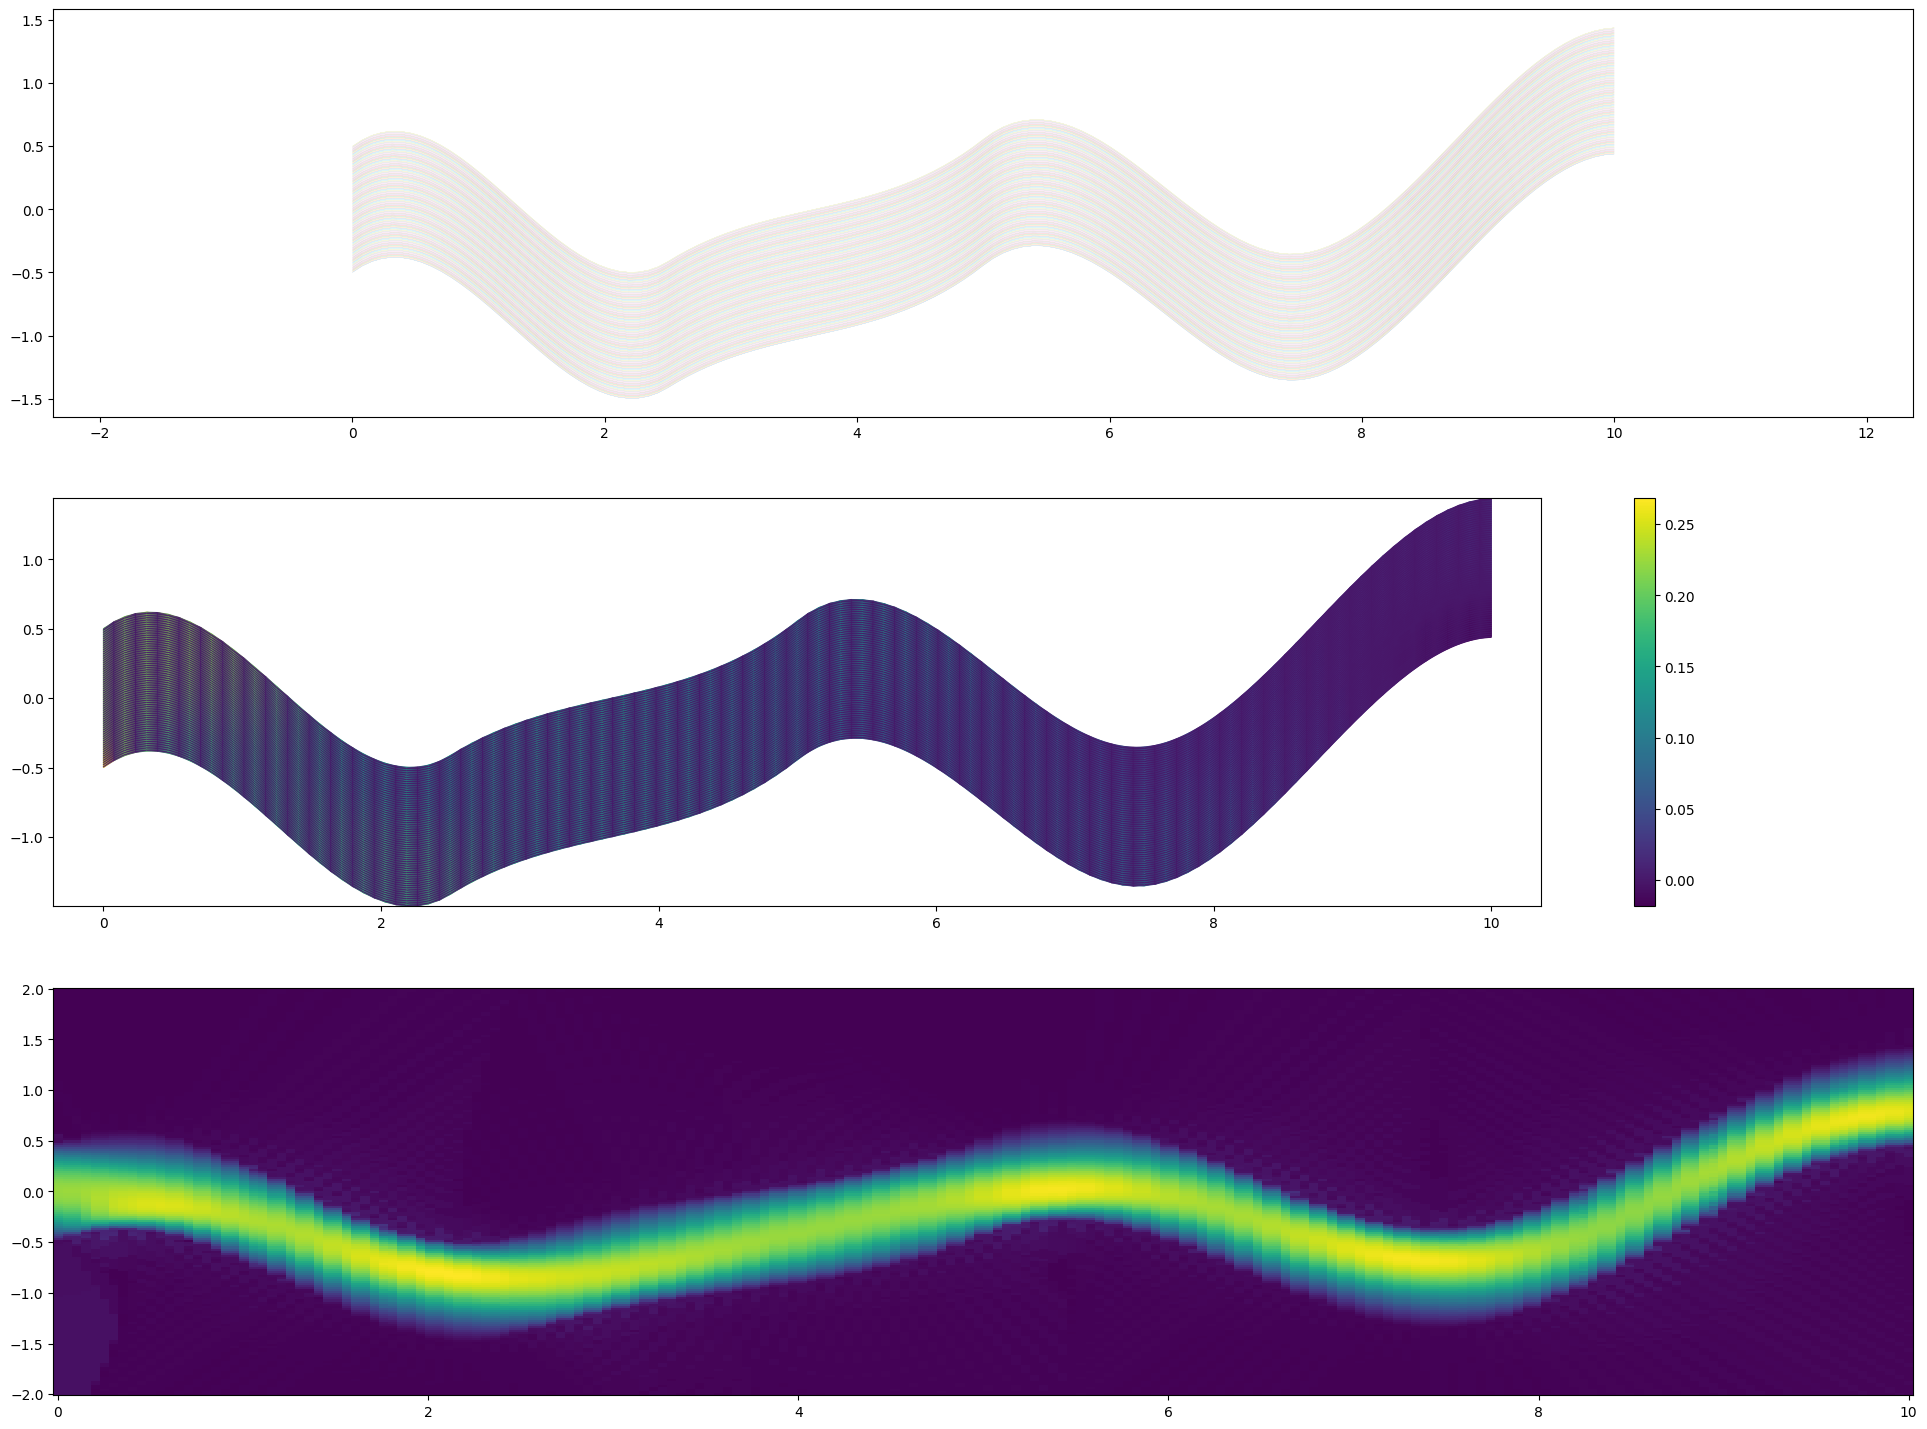

In [7]:
import matplotlib.pyplot as plt



fig,ax=plt.subplots(3,1,figsize=(24,18))
# Plot the original meshgrid
im0=ax[0].plot(randPipeX, randPipeY, '-', linewidth=0.1)
im1 = ax[1].pcolormesh(randPipeX,randPipeY, randQ[2,:,:], shading='gouraud')
im2= ax[2].pcolormesh(heatobj.xgrid,heatobj.ygrid,heatobj.u[:,:,0])
#ax1.plot(randPipeX.T, randPipeY.T, 'b-', linewidth=0.5)

ax[0].axis('equal')

fig.colorbar(im1, ax = ax[1])
ax[1].axis('equal')


# Display the plot
plt.show()
